In [1]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu

# this sets up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# this sets up astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table

from regions import Regions, CircleSkyRegion

Now, we look at a big catalog from COSMOS-Web, compiled by Hollis Akins.

In [3]:
# this is the name of the BIG catalog file
large_catalog = '/Users/ngbinh/Downloads/COSMOS-Web_supercatalog_v0.7.fits'

In [4]:
# this opens the HDU list of the .fits files and asks for the information within. SCI is what we'll use
hdu_list = fits.open(large_catalog)
hdu_list.info()

# this saves the WCS setting to be used later
wcs = WCS(hdu_list[1].header)

Filename: /Users/ngbinh/Downloads/COSMOS-Web_supercatalog_v0.7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    802   913253R x 155C   [K, D, D, 3A, D, 4A, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, K, E, E, K, L, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, L, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [5]:
# this gets the data of the big catalog. "cat" stands for catalog!
cat_data = hdu_list[1].data

In [6]:
print(cat_data.columns.names)

['id', 'ra', 'dec', 'tile', 'chi2_max', 'mode', 'obs_f814w', 'snr_f814w', 'wht_f814w', 'f_auto_f814w', 'e_auto_f814w', 'm_auto_f814w', 'f_seg_f814w', 'e_seg_f814w', 'm_seg_f814w', 'f_aper_f814w', 'e_aper_f814w', 'm_aper_f814w', 'obs_f115w', 'snr_f115w', 'wht_f115w', 'f_auto_f115w', 'e_auto_f115w', 'm_auto_f115w', 'f_seg_f115w', 'e_seg_f115w', 'm_seg_f115w', 'f_aper_f115w', 'e_aper_f115w', 'm_aper_f115w', 'obs_f150w', 'snr_f150w', 'wht_f150w', 'f_auto_f150w', 'e_auto_f150w', 'm_auto_f150w', 'f_seg_f150w', 'e_seg_f150w', 'm_seg_f150w', 'f_aper_f150w', 'e_aper_f150w', 'm_aper_f150w', 'obs_f277w', 'snr_f277w', 'wht_f277w', 'f_auto_f277w', 'e_auto_f277w', 'm_auto_f277w', 'f_seg_f277w', 'e_seg_f277w', 'm_seg_f277w', 'f_aper_f277w', 'e_aper_f277w', 'm_aper_f277w', 'obs_f444w', 'snr_f444w', 'wht_f444w', 'f_auto_f444w', 'e_auto_f444w', 'm_auto_f444w', 'f_seg_f444w', 'e_seg_f444w', 'm_seg_f444w', 'f_aper_f444w', 'e_aper_f444w', 'm_aper_f444w', 'obs_f770w', 'snr_f770w', 'wht_f770w', 'f_auto_f770w

In [7]:
# this gets the redshift of all the galaxies
z_spec = cat_data['z_spec']

In [8]:
# closes the data file
hdu_list.close()

In [9]:
# create an empty 2D array to put the ID, RA and DEC of galaxies into
big_cat_ra_dec = np.empty(shape=(np.size(cat_data), 3), dtype='float')

In [10]:
# put the ID, RA and DEC of galaxies in the big catalog into the previously made array
for i in range(np.size(cat_data)):
    ra_dec = np.array(cat_data[i][0:3])
    big_cat_ra_dec[i] = ra_dec

In [11]:
# this reads in the new confirmed QG catalog and skips the header
df = pd.read_csv('/Users/ngbinh/Downloads/spec_qgs.txt', sep="\s+", header = None, names=['Name', 'RA', 'Dec', 'Redshift'], skiprows=1)

# this saves the data frame as a numpy array of RA and Dec for later usage.
# remember: first column is RA, second is Dec, third is redshift.
spec_qg_ra_dec = df.to_numpy()[1:][:,1:3]
spec_qg_ra_dec = np.vstack(spec_qg_ra_dec).astype(float) # converting dtype from object to float

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_5223/1030496139.py:2: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('/Users/ngbinh/Downloads/spec_qgs.txt', sep="\s+", header = None, names=['Name', 'RA', 'Dec', 'Redshift'], skiprows=1)


In [12]:
spec_qg_cat = SkyCoord(ra=spec_qg_ra_dec[:,0]*u.degree, dec=spec_qg_ra_dec[:,1]*u.degree)
all_cat = SkyCoord(ra=big_cat_ra_dec[:,1]*u.degree, dec=big_cat_ra_dec[:,2]*u.degree)

In [13]:
# now, we search for all the neighbors of the quenched galaxies, within a given distance

dist_new = 1 # trying not to hardcode the distance here just in case we need to change it
idx_spec, idx_maybe, d2d, d3d = all_cat.search_around_sky(spec_qg_cat, dist_new*u.arcsec)
np.all(d2d < dist_new*u.arcsec)

True

In [14]:
# these are the matches
print(df.loc[idx_spec, "Name"])

0      ZF-UDS-7329
1     ZF-COS-20115
17        XMM-2599
17        XMM-2599
17        XMM-2599
20         GS-9209
27    3D-UDS-27939
28    ZF-COS-20032
29    ZF-COS-19589
29    ZF-COS-19589
30    ZF-COS-18842
Name: Name, dtype: object


From this result, we know there are 4 spectroscopically confirmed QGs that are in our catalog: ZF-COS-20115, ZF-COS-20032, ZF-COS-19589 and ZF-COS-18842.

In [16]:
# now, we get the indices of the galaxies that match (just call them "matches" for now)
matches_idx = np.array([1, 28, 29, 30])

# then, get their RAs, Decs and redshifts
matches_catalog_names = df.loc[matches_idx, "Name"].to_numpy()
matches_ra = df.loc[matches_idx, "RA"].to_numpy() # reminder: unit is in degrees
matches_dec = df.loc[matches_idx, "Dec"].to_numpy() # reminder: unit is in degrees
matches_redshift = df.loc[matches_idx, "Redshift"].to_numpy() * cu.redshift

New step (May 17, 2024): 5 more quenched galaxies have been discovered. Let's add them!

From now on, for the sake of memorability, these important quenched galaxies will be named after the rivers of Vietnam. The reason is because Vietnam (my homeland) is a country with MANY, MANY rivers (a limitless source of names), and because galaxies are referred to as "thiên hà" (heavenly rivers) in Vietnamese.

In [19]:
# new step (May 17, 2024): 5 more quenched galaxies have been discovered. let's add them here
matches_ra = np.concatenate((matches_ra, np.array([150.43732, 150.45459, 150.46120, 150.106932, 150.108873])), axis=0)
matches_dec = np.concatenate((matches_dec, np.array([2.463920, 2.455994, 2.429547, 2.377961, 2.330539])), axis=0)
matches_redshift = np.concatenate((matches_redshift, np.array([3.336, 3.757, 4.673, 4.570, 3.238])), axis=0)

In [20]:
print(matches_ra, matches_dec, matches_redshift)

[150.06149  150.11256  150.06671  150.08728  150.43732  150.45459
 150.4612   150.106932 150.108873] [2.37868   2.3765266 2.3823645 2.3960431 2.46392   2.455994  2.429547
 2.377961  2.330539 ] [3.715 2.474 3.715 3.782 3.336 3.757 4.673 4.57  3.238] redshift


In [21]:
# let's print out some reminders about the galaxies and their names
matches_names = np.array(['Hong', 'Bach-Dang', 'Thu-Bon', 'Gianh', 'Ben-Hai', 'Tien', 'Hau', 'Dong-Nai', 'Saigon'])

In [22]:
matches_cat = SkyCoord(ra=matches_ra*u.degree, dec=matches_dec*u.degree)

In [23]:
# next, we use 35 kpc (from Suess et al, 2023) and the redshifts of the matches 
# to find a corresponding searching radius for neighbors around each of them.
d_Suess = 35 * u.kpc

In [24]:
# then, get a corresponding distance from each redshift, and then an angular size
matches_distance = cosmo.kpc_proper_per_arcmin(matches_redshift)
angular_sizes = (d_Suess / matches_distance).to(u.arcsec)

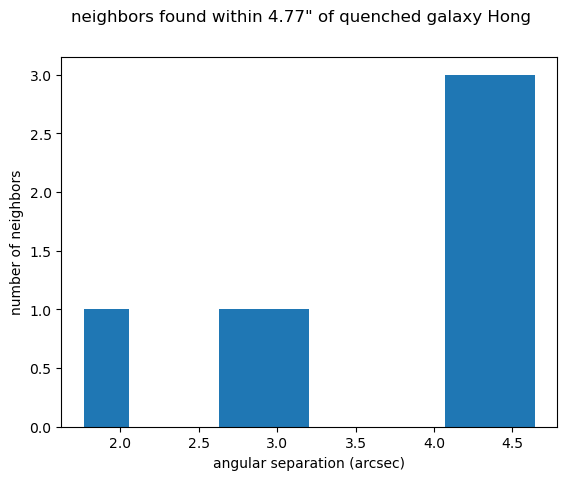

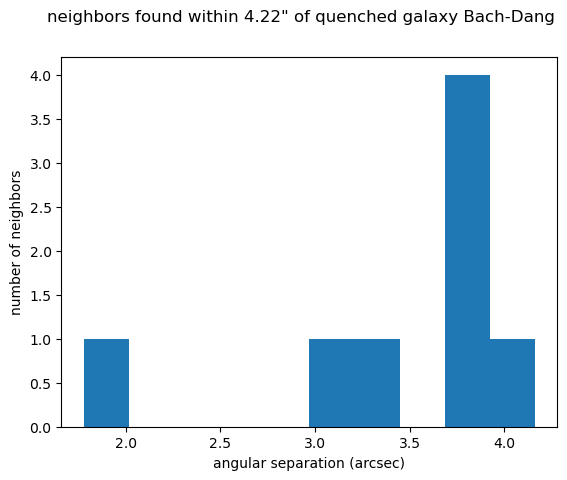

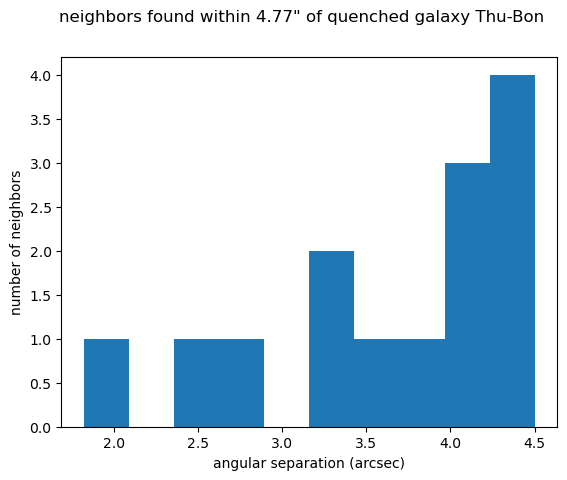

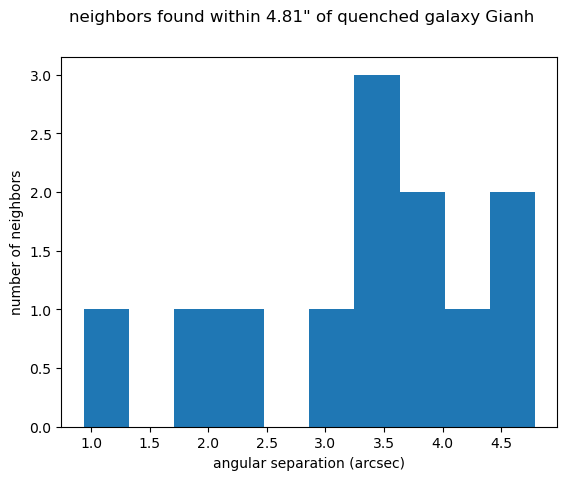

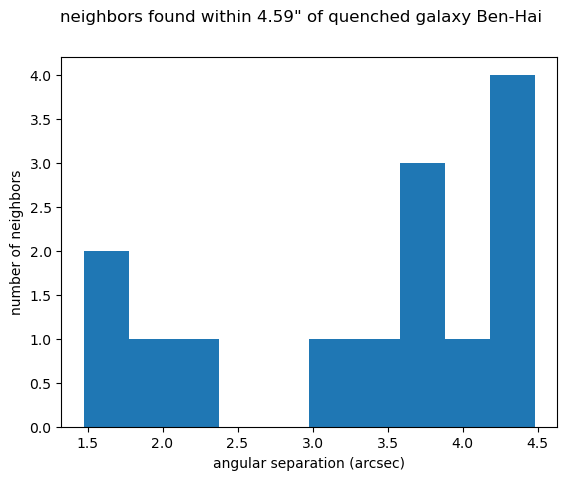

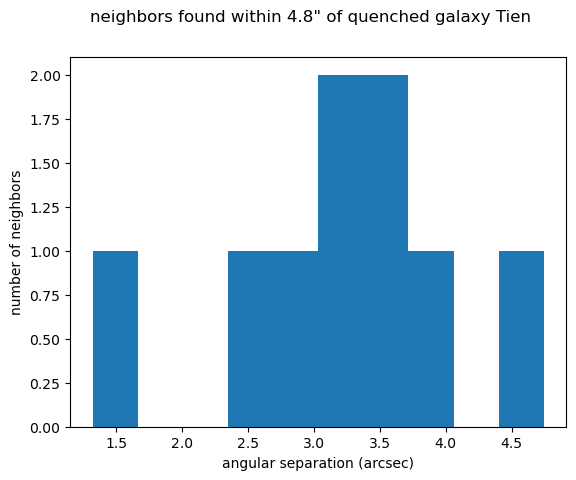

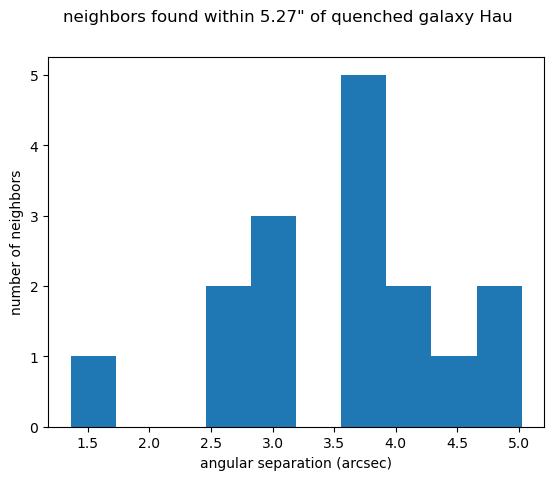

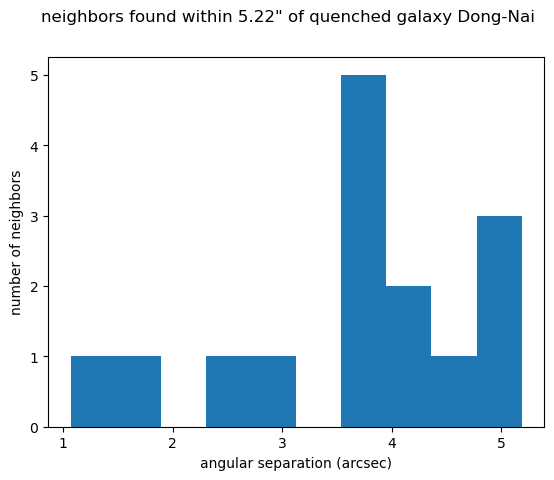

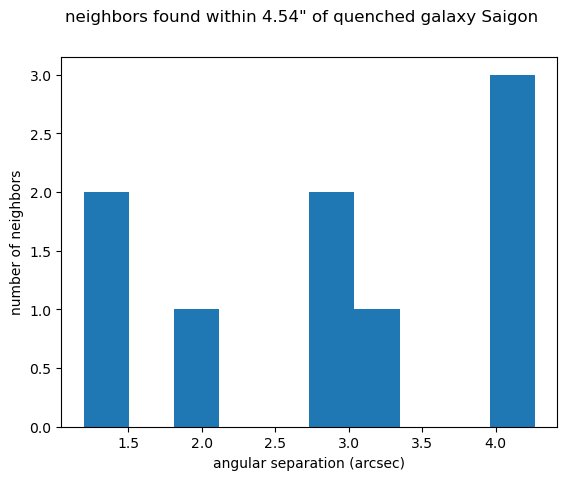

In [51]:
### now, loop through each of the matches, use the corresponding angular size
### and search for neighbors within that angular size
which_is_which = []

### this creates a mega list that will be converted into a pandas dataframe
mega_list = []

for galax in range(np.size(angular_sizes)):
    ### first, call the RA and Dec of the matched QG and its corresponding angular size (aka search radius)
    matches_proper_ra = matches_ra[galax]
    matches_proper_dec = matches_dec[galax]
    matches_ra_dec = matches_cat[galax]
    matches_name = matches_names[galax]
    search_radius = angular_sizes[galax]

    ### now, search for neighbors
    d2d = matches_ra_dec.separation(all_cat)
    catalog_mask = d2d < search_radius
    
    ### now, match the neighbors' indices with their RA and Dec
    matches_near_ra = big_cat_ra_dec[:,1][catalog_mask] # in degrees
    matches_near_dec = big_cat_ra_dec[:,2][catalog_mask] # in degrees
    matches_near_redshift = z_spec[catalog_mask] # no unit

    ### but, unfortunately, these will include the central galaxies themselves, so let's get rid of that
    # first, let's make an empty array of separations
    sep_array = np.zeros(np.size(matches_near_ra))

    # then, use the separation function in astropy to calculate the sky distance between the central galaxy's coords
    # and the coords of each "nearby" galaxy, which now includes the central galaxy and we need to get rid of that
    for j in range(np.size(matches_near_ra)):
        center = SkyCoord(ra=matches_proper_ra*u.degree, dec=matches_proper_dec*u.degree, frame='icrs')
        nearby = SkyCoord(ra=matches_near_ra[j]*u.degree, dec=matches_near_dec[j]*u.degree, frame='fk5')
        sep = center.separation(nearby)
        sep_array[j] = sep.value

    # now, having calculated all the sky distances, we remove the object with the minimum 
    # sky distance/separation, which will correspond to the central galaxy
    matches_near_ra = matches_near_ra[sep_array != min(sep_array)]
    matches_near_dec = matches_near_dec[sep_array != min(sep_array)]
    matches_near_redshift = matches_near_redshift[sep_array != min(sep_array)]

    # now, add the neighbors into a BIG table that we can use to make postage stamps and more
    neighbor_array = np.zeros(np.size(matches_near_ra))
    for idx in range(np.size(matches_near_ra)):
        # first, locate the row that matches the RA and Dec of the neighbor
        neighbor_idx = np.where(cat_data['ra'] == matches_near_ra[idx])
        all_neighbor_data = cat_data[neighbor_idx]

        # this keeps track of which galaxy these neighbors are, well, neighbors of
        which_is_which.append(galax)

        # this adds the neighbor's data into our big list
        mega_list.append(list(all_neighbor_data[0]))
    
    # now, subtract to get delta_RA and delta_Dec.
    del_ra_matches = np.abs(matches_proper_ra - matches_near_ra) # in degrees
    del_dec_matches = np.abs(matches_proper_dec - matches_near_dec) # in degrees

    # now, we convert the array from degrees into arcsecs for clarity, then take the vector delta
    del_vector_matches = np.sqrt((del_ra_matches*u.degree.to(u.arcsec))**2 + (del_dec_matches*u.degree.to(u.arcsec))**2)

    # now make histograms summarizing the angular separations
    fig, ax = plt.subplots(1, 1)
    fig.suptitle('neighbors found within ' + str(np.round(search_radius.value, 2)) \
                 + '" of quenched galaxy ' + matches_name) # using "str" to avoid hardcoding
    ax.hist(del_vector_matches) # this converts the array from degrees into arcsecs for clarity
    ax.set(xlabel='angular separation (arcsec)', ylabel='number of neighbors')
    
    fig.savefig('river_hist/hist' + matches_name + '.png')

In [57]:
# finally, this converts the mega list into a saveable data frame
df_mega = pd.DataFrame(mega_list, columns=cat_data.columns.names)

In [59]:
df_final = df_mega.assign(our_id=which_is_which)

In [61]:
# this saves the data frame
df_final.to_csv('neighbor_data.csv', index=False)